<a href="https://colab.research.google.com/github/ajaysuseel/MiniProject_AD/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import json
import requests
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch.nn.functional as F
from tqdm import tqdm


#CONFIGURABLE VARIABLES

In [2]:
# Configurable variables
GITHUB_REPO = "https://raw.githubusercontent.com/ajaysuseel/MiniProject_AD/main/ajay/"
JSON_FILE = "captions.json"
IMAGES_FOLDER = "images/"

#Function: Load BLIP Model

In [3]:
def load_blip_model():
    model_name = "Salesforce/blip-image-captioning-base"
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForConditionalGeneration.from_pretrained(model_name)
    return model, processor

#Function: Load Dataset from GitHub

In [4]:
def load_dataset():
    json_url = GITHUB_REPO + JSON_FILE
    try:
        response = requests.get(json_url)
        response.raise_for_status()
        data = response.json()
        print(f"Loaded {len(data)} image-caption pairs.")
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error loading dataset: {e}")
        return []

#Custom Dataset Class

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, data, processor, images_dir):
        self.data = data
        self.processor = processor
        self.images_dir = images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_url = self.images_dir + item["filename"]

        try:
            image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
        except Exception as e:
            print(f"Error loading image {item['filename']}: {e}")
            return None

        encoding = self.processor(
            text=item["description"],
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding["labels"] = encoding["input_ids"]
        return encoding

#Create DataLoader

In [6]:
def create_dataloader(data, processor, batch_size=4):
    dataset = CaptionDataset(data, processor, GITHUB_REPO + IMAGES_FOLDER)

    def collate_fn(batch):
        batch = [b for b in batch if b is not None]
        if len(batch) == 0:
            return None
        keys = batch[0].keys()
        return {key: torch.stack([b[key] for b in batch]) for key in keys}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

#Train Model

In [7]:
def train_blip(model, dataloader, num_epochs=3, learning_rate=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(f"🚀 Starting fine-tuning on {device} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"✅ Epoch {epoch+1} completed | Average Loss: {epoch_loss:.4f}")

    model.save_pretrained("./models/finetuned_blip1")
    processor.save_pretrained("./models/finetuned_blip1")
    print("🎯 Fine-tuning complete and model saved!")

In [8]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [9]:
if __name__ == "__main__":
    model, processor = load_blip_model()
    data = load_dataset()

    if not data:
        print("No data found. Exiting.")
    else:
        dataloader = create_dataloader(data, processor)
        if dataloader is None:
            print("Error: No valid data samples found. Exiting.")
        else:
            train_blip(model, dataloader, num_epochs=20)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loaded 10 image-caption pairs.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

🚀 Starting fine-tuning on cuda for 20 epochs...



Epoch 1/20: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, loss=9.54]


✅ Epoch 1 completed | Average Loss: 32.6629


Epoch 2/20: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it, loss=8.55]


✅ Epoch 2 completed | Average Loss: 26.3809


Epoch 3/20: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it, loss=8.13]


✅ Epoch 3 completed | Average Loss: 24.7389


Epoch 4/20: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it, loss=7.69]


✅ Epoch 4 completed | Average Loss: 23.5742


Epoch 5/20: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it, loss=7.28]


✅ Epoch 5 completed | Average Loss: 22.3248


Epoch 6/20: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it, loss=6.87]


✅ Epoch 6 completed | Average Loss: 21.0901


Epoch 7/20: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it, loss=6.56]


✅ Epoch 7 completed | Average Loss: 19.9610


Epoch 8/20: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it, loss=6.11]


✅ Epoch 8 completed | Average Loss: 18.7989


Epoch 9/20: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=5.78]


✅ Epoch 9 completed | Average Loss: 17.7167


Epoch 10/20: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it, loss=5.39]


✅ Epoch 10 completed | Average Loss: 16.5888


Epoch 11/20: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=5.03]


✅ Epoch 11 completed | Average Loss: 15.4624


Epoch 12/20: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it, loss=4.63]


✅ Epoch 12 completed | Average Loss: 14.3040


Epoch 13/20: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it, loss=4.25]


✅ Epoch 13 completed | Average Loss: 13.1495


Epoch 14/20: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=3.86]


✅ Epoch 14 completed | Average Loss: 11.9893


Epoch 15/20: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=3.48]


✅ Epoch 15 completed | Average Loss: 10.8369


Epoch 16/20: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it, loss=3.12]


✅ Epoch 16 completed | Average Loss: 9.6929


Epoch 17/20: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it, loss=2.74]


✅ Epoch 17 completed | Average Loss: 8.5517


Epoch 18/20: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it, loss=2.35]


✅ Epoch 18 completed | Average Loss: 7.4270


Epoch 19/20: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it, loss=1.99]


✅ Epoch 19 completed | Average Loss: 6.3432


Epoch 20/20: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it, loss=1.67]


✅ Epoch 20 completed | Average Loss: 5.3262
🎯 Fine-tuning complete and model saved!


In [10]:
!git config --global user.name "ajaysuseel"
!git config --global user.email "ajaysuseel673@gmail.com"
!git clone https://github.com/ajaysuseel/MiniProject_AD.git
!cp -r ./models ./MiniProject_AD/





Cloning into 'MiniProject_AD'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 216 (delta 52), reused 154 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 27.84 MiB | 20.22 MiB/s, done.
Resolving deltas: 100% (52/52), done.
[Errno 2] No such file or directory: 'MiniProject_AD # Move into the repo'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [11]:
%cd MiniProject_AD
!git add models  # Add the models folder
!git commit -m "Added fine-tuned BLIP model"
!git push origin main  # Push to the main branch

/content/MiniProject_AD
[main d0c9df4] Added fine-tuned BLIP model
 8 files changed, 61370 insertions(+)
 create mode 100644 models/finetuned_blip1/config.json
 create mode 100644 models/finetuned_blip1/generation_config.json
 create mode 100644 models/finetuned_blip1/model.safetensors
 create mode 100644 models/finetuned_blip1/preprocessor_config.json
 create mode 100644 models/finetuned_blip1/special_tokens_map.json
 create mode 100644 models/finetuned_blip1/tokenizer.json
 create mode 100644 models/finetuned_blip1/tokenizer_config.json
 create mode 100644 models/finetuned_blip1/vocab.txt
fatal: could not read Username for 'https://github.com': No such device or address


#Evaluation

In [12]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import matplotlib.pyplot as plt

In [13]:
IMAGE_FOLDER = "/content/MiniProject_AD/pranav/images"  # Image folder
CAPTIONS_FILE = "/content/MiniProject_AD/pranav/captions.json"  # JSON with filename-description
MODEL_PATH = "./models/finetuned_blip1"  # Fine-tuned BLIP model path

In [14]:
def load_model_and_processor(model_path):
    try:
        processor = BlipProcessor.from_pretrained(model_path)
        model = BlipForConditionalGeneration.from_pretrained(model_path)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        print(f"✅ Model loaded on {device}")
        return model, processor, device
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None
def load_ground_truth(local_json_path):
    try:
        with open(local_json_path, "r") as f:
            gt_data = json.load(f)
            gt_data = {item["filename"]: item["description"] for item in gt_data}
        print(f"✅ Loaded {len(gt_data)} ground truth captions.")
        return gt_data
    except Exception as e:
        print(f"❌ Error loading ground truth: {e}")
        return {}
def load_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        return image
    except Exception as e:
        print(f"❌ Error loading image {image_path}: {e}")
        return None


In [15]:
def generate_caption(model, processor, device, image):
    try:
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            output_ids = model.generate(**inputs)
        return processor.decode(output_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"❌ Error generating caption: {e}")
        return ""

In [16]:
def display_image_with_captions(image_path, gt_caption, generated_caption, bleu_score):
    image = load_image(image_path)
    if image is None:
        return
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"GT: {gt_caption}\nGen: {generated_caption}\nBLEU: {bleu_score:.4f}", fontsize=10)
    plt.show()


In [17]:
def evaluate_model(image_folder, gt_json_path, model_path):
    gt_captions = load_ground_truth(gt_json_path)
    if not gt_captions:
        print("❌ No ground truth data available. Exiting evaluation.")
        return

    model, processor, device = load_model_and_processor(model_path)
    if model is None:
        print("❌ Model loading failed. Exiting evaluation.")
        return

    generated_captions = {}
    references = []
    hypotheses = []

    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"🔹 Found {len(image_files)} images in {image_folder}.")

    for filename in tqdm(image_files, desc="Evaluating Images"):
        if filename not in gt_captions:
            continue

        image_path = os.path.join(image_folder, filename)
        image = load_image(image_path)
        if image is None:
            continue

        gen_caption = generate_caption(model, processor, device, image)
        generated_captions[filename] = gen_caption

        # Compute BLEU score
        hypothesis = gen_caption.split()
        reference = [gt_captions[filename].split()]  # BLEU expects a list of references
        score = sentence_bleu(reference, hypothesis)

        # Store for corpus BLEU calculation
        references.append(reference)
        hypotheses.append(hypothesis)

        # Display image with captions
        display_image_with_captions(image_path, gt_captions[filename], gen_caption, score)

    # Compute Corpus BLEU Score
    corpus_bleu_score = corpus_bleu(references, hypotheses)
    print("\n--- Evaluation Summary ---")
    print(f"📊 Corpus BLEU Score: {corpus_bleu_score:.4f}")


✅ Loaded 10 ground truth captions.
✅ Model loaded on cuda
🔹 Found 10 images in /content/MiniProject_AD/pranav/images.


Evaluating Images:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower 

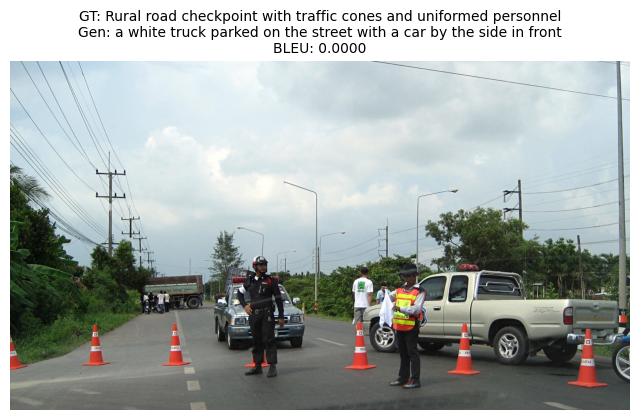

Evaluating Images:  10%|█         | 1/10 [00:00<00:08,  1.02it/s]

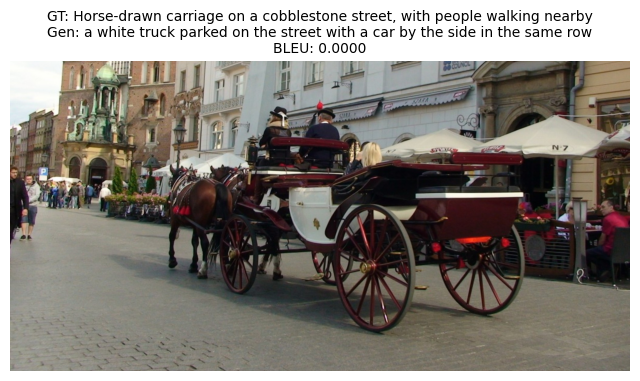

Evaluating Images:  20%|██        | 2/10 [00:01<00:07,  1.09it/s]

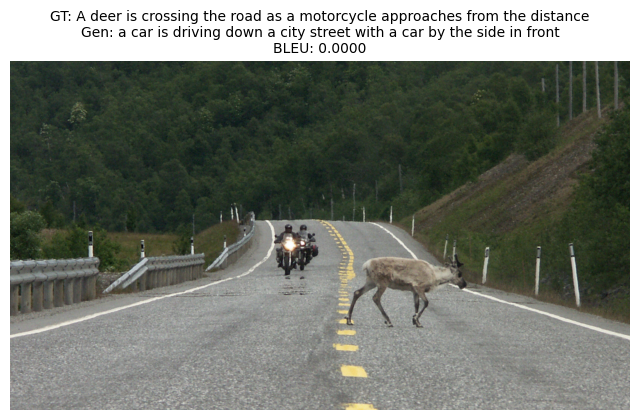

Evaluating Images:  30%|███       | 3/10 [00:02<00:05,  1.21it/s]

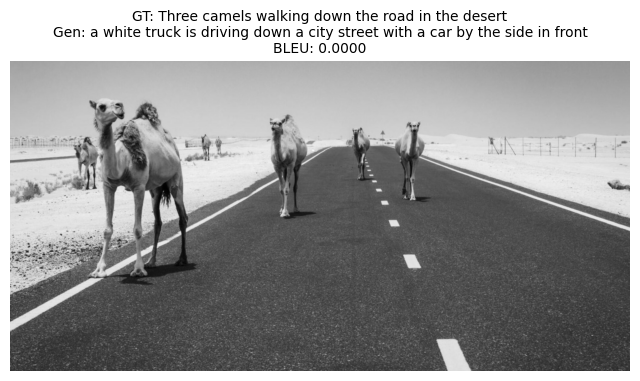

Evaluating Images:  40%|████      | 4/10 [00:03<00:04,  1.26it/s]

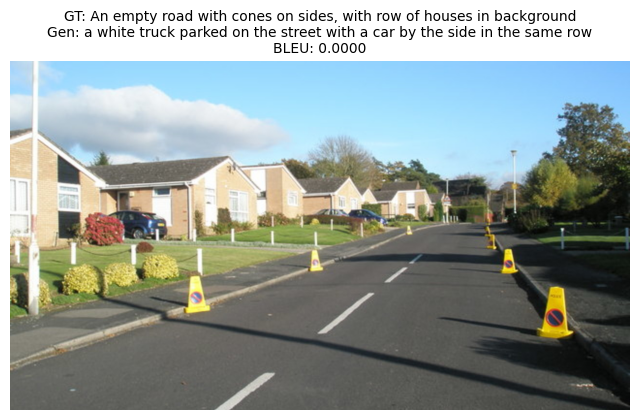

Evaluating Images:  50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

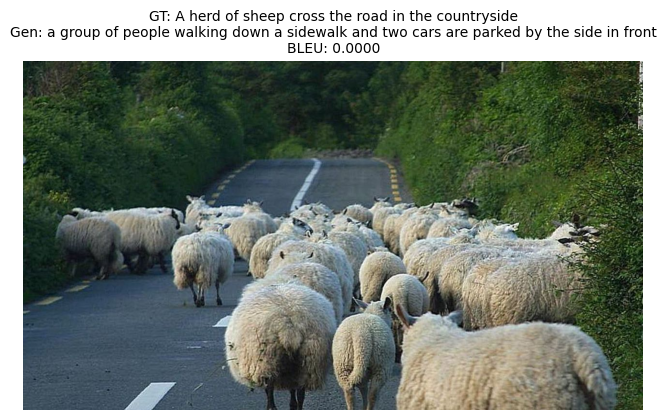

Evaluating Images:  60%|██████    | 6/10 [00:04<00:02,  1.39it/s]

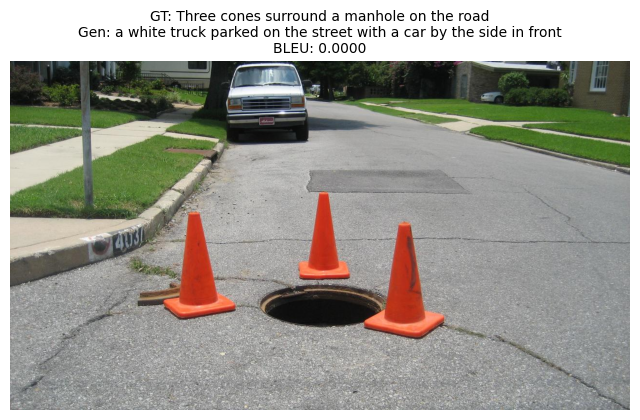

Evaluating Images:  70%|███████   | 7/10 [00:05<00:02,  1.38it/s]

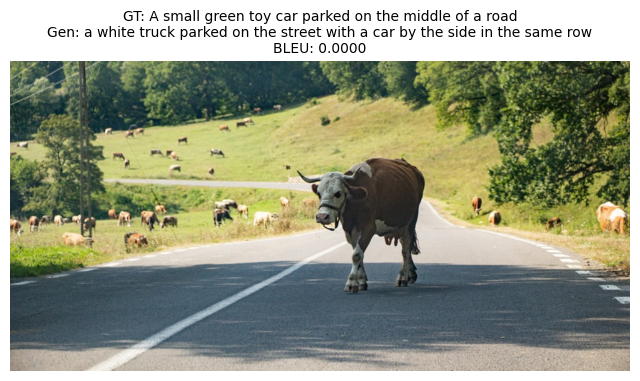

Evaluating Images:  80%|████████  | 8/10 [00:06<00:01,  1.33it/s]

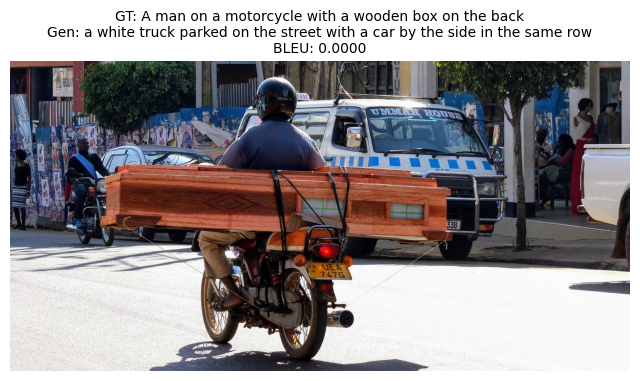

Evaluating Images:  90%|█████████ | 9/10 [00:07<00:00,  1.29it/s]

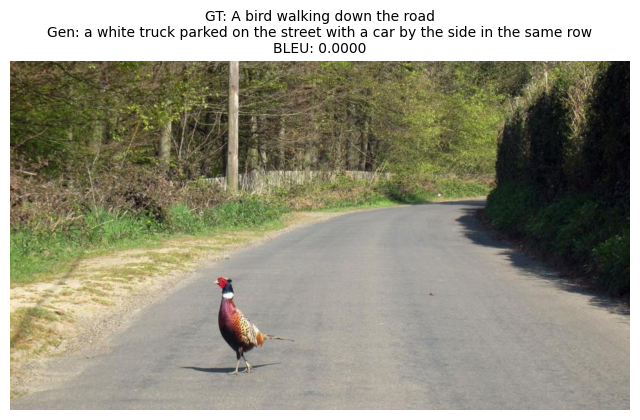

Evaluating Images: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


--- Evaluation Summary ---
📊 Corpus BLEU Score: 0.0000


In [18]:
evaluate_model(IMAGE_FOLDER, CAPTIONS_FILE, MODEL_PATH)